In [1]:
import datajoint as dj
from scipy import signal
import numpy as np

dj.config["enable_python_native_blobs"] = True
dj.config['database.host'] = '130.223.197.5:3305' 
dj.config['database.user'] = 'root'
dj.config['database.password'] = 'dbD9pzum@RifRaf'
ConnMessage=dj.conn()

import matplotlib.pyplot as plt
from scipy import stats
from Schema import lcProj
from Schema.mouse_inject_lc_proj import inject_mice_csv_batch, inject_sessions
import LC_Peaks.LC_peak_detection.pythonProject.lcProj
all_schemas=dj.list_schemas()
from Schema.UsefulFunctions import findPosFromTimestamps
import os

[2024-05-31 16:19:07,919][INFO]: Connecting root@130.223.197.5:3305
[2024-05-31 16:19:07,967][INFO]: Connected root@130.223.197.5:3305


In [2]:
mouseListAmyg = ["AMYG01","AMYG02", "AMYG03"]

peaksAmygMA = []
peaksAmygNonMA = []

deltaAmygMA = []
deltaAmygNonMA = []

sigmaAmygMA = []
sigmaAmygNonMA = []

gammaAmygMA = []
gammaAmygNonMA = []

for m in mouseListAmyg:

    key = {'mouse_name':m}
    
    print('Doing mouse:' + m)
    
    peaksAmygMAMouse = []
    peaksAmygNonMAMouse = []
    
    sigmaAmygMAMouse = []
    sigmaAmygNonMAMouse = []
    
    deltaAmygMAMouse = []
    deltaAmygNonMAMouse = []
    
    gammaAmygMAMouse = []
    gammaAmygNonMAMouse = []
    
    dates  = (lcProj.LCPeaks & key)
    
    for d in dates:
        
        print('Doing date:' +  d['session_date'])
        
        peaks = d['lc_peaks']
        peaksFlag = d['peaks_flag']
        dff = (lcProj.FibDFF & d).fetch1('dff')
        dff = (dff-np.mean(dff))/np.std(dff)
        times = (lcProj.FibDFF & d).fetch1('timestamps')
        dt = int(1/np.mean(np.diff(times)))
        
        delta = (lcProj.MGT & d).fetch1('delta')
        delta = (delta - np.mean(delta)) / np.std(delta)
        
        sigma = (lcProj.MGT & d).fetch1('sigma')
        sigma = (sigma - np.mean(sigma)) / np.std(sigma)
        
        gamma = (lcProj.MGT & d).fetch1('gamma')
        gamma = (gamma - np.mean(sigma)) / np.std(gamma)
        
        timeMGT = np.arange(0, delta.shape[0] / 100, 1 / 100)
        
        dtDff = int(1 / np.mean(np.diff(times)))
        dtMGT = int(1 / np.mean(np.diff(timeMGT)))
        
        FiftySecDff = 50 * dtDff
        FiftySecMGT = 50 * dtMGT
        
        peaksMA = []
        peaksNonMA = []
        
        deltaMA = []
        deltaNonMA = []
        
        sigmaMA = []
        sigmaNonMA = []
        
        gammaMA = []
        gammaNonMA = []
        
        for i, p in enumerate(peaks):
    
            if peaksFlag[i]:
                
                dffChunk =  dff[(p - FiftySecDff):(p + FiftySecDff)]
                
                timeInDff = times[p]
                
                posMGT = findPosFromTimestamps(timeMGT,  timeInDff)
                
                if dffChunk.shape[0] == 2*FiftySecDff:
                    
                    peaksMA.append(dff[(p - FiftySecDff):(p + FiftySecDff)])
                    
                    deltaMA.append(delta[(posMGT - FiftySecMGT):(posMGT + FiftySecMGT)])
                    
                    sigmaMA.append(sigma[(posMGT - FiftySecMGT):(posMGT + FiftySecMGT)])
                    
                    gammaMA.append(gamma[(posMGT - FiftySecMGT):(posMGT + FiftySecMGT)])
                    
                else: 
                    print('Happened at mouse: ' + m)            
                    
            else:
                dffChunk =  dff[(p - FiftySecDff):(p + FiftySecDff)]
                      
                timeInDff = times[p]
                
                posMGT = findPosFromTimestamps(timeMGT,  timeInDff)
                
                if dffChunk.shape[0] == 2* FiftySecDff:
                    
                    peaksNonMA.append(dff[(p - FiftySecDff):(p + FiftySecDff)])
                    
                    deltaNonMA.append(delta[(posMGT - FiftySecMGT):(posMGT + FiftySecMGT)])
                    
                    sigmaNonMA.append(sigma[(posMGT - FiftySecMGT):(posMGT + FiftySecMGT)])
                    
                    gammaNonMA.append(gamma[(posMGT - FiftySecMGT):(posMGT + FiftySecMGT)])
                else: 
                    print('Happened at mouse: ' + m)            
        
        peaksMA = np.array(peaksMA)
        peaksNonMA = np.array(peaksNonMA)
        
        deltaMA = np.array(deltaMA)
        deltaNonMA = np.array(deltaNonMA)
        
        sigmaMA = np.array(sigmaMA)
        sigmaNonMA = np.array(sigmaNonMA)
        
        gammaMA = np.array(gammaMA)
        gammaNonMA = np.array(gammaNonMA)
        
        
        meanPeaksMA = np.mean(peaksMA,0)
        meanPeaksNonMA = np.mean(peaksNonMA,0)
        
        meanDeltaMA = np.mean(deltaMA,0)
        meanDeltaNonMA = np.mean(deltaNonMA,0)

        meanSigmaMA = np.mean(sigmaMA,0)
        meanSigmaNonMA = np.mean(sigmaNonMA,0)
        
        meanGammaMA = np.mean(gammaMA,0)
        meanGammaNonMA = np.mean(gammaNonMA,0)
        
        if meanPeaksMA.shape[0]<6000 or meanPeaksMA.shape[0]>6000:
    
            meanPeaksMA = signal.resample(meanPeaksMA , 6000)
            meanPeaksNonMA = signal.resample(meanPeaksNonMA , 6000)
        
        peaksAmygMAMouse.append(meanPeaksMA)
        peaksAmygNonMAMouse.append(meanPeaksNonMA)
        
        deltaAmygMAMouse.append(meanDeltaMA)
        deltaAmygNonMAMouse.append(meanDeltaNonMA)
        
        sigmaAmygMAMouse.append(meanSigmaMA)
        sigmaAmygNonMAMouse.append(meanSigmaNonMA)
        
        gammaAmygMAMouse.append(meanGammaMA)
        gammaAmygNonMAMouse.append(meanGammaNonMA)
    
    
    peaksAmygMAMouse = np.array(peaksAmygMAMouse)
    peaksAmygNonMAMouse = np.array(peaksAmygNonMAMouse)
        
    deltaAmygMAMouse = np.array(deltaAmygMAMouse)
    deltaAmygNonMAMouse = np.array(deltaAmygNonMAMouse)
    
    sigmaAmygMAMouse = np.array(sigmaAmygMAMouse)
    sigmaAmygNonMAMouse = np.array(sigmaAmygNonMAMouse)
    
    gammaAmygMAMouse = np.array(gammaAmygMAMouse)
    gammaAmygNonMAMouse = np.array(gammaAmygNonMAMouse)

    peaksAmygMA.append(np.mean(peaksAmygMAMouse,0))
    peaksAmygNonMA.append(np.mean(peaksAmygNonMAMouse,0))
    
    deltaAmygMA.append(np.mean(deltaAmygMAMouse,0))
    deltaAmygNonMA.append(np.mean(deltaAmygNonMAMouse,0))
    
    sigmaAmygMA.append(np.mean(sigmaAmygMAMouse,0))
    sigmaAmygNonMA.append(np.mean(sigmaAmygNonMAMouse,0))
    
    gammaAmygMA.append(np.mean(gammaAmygMAMouse,0))
    gammaAmygNonMA.append(np.mean(gammaAmygNonMAMouse,0))


peaksAmygMA = np.array(peaksAmygMA)
peaksAmygNonMA = np.array(peaksAmygNonMA)

deltaAmygMA = np.array(deltaAmygMA)
deltaAmygNonMA = np.array(deltaAmygNonMA)

sigmaAmygMA = np.array(sigmaAmygMA)
sigmaAmygNonMA = np.array(sigmaAmygNonMA)

gammaAmygMA = np.array(gammaAmygMA)
gammaAmygNonMA = np.array(gammaAmygNonMA)


mouseListHip = ["MHIP03","MHIP05","MHIP06"]

peaksHipMA = []
peaksHipNonMA = []

deltaHipMA = []
deltaHipNonMA = []

sigmaHipMA = []
sigmaHipNonMA = []

gammaHipMA = []
gammaHipNonMA = []

for m in mouseListHip:

    key = {'mouse_name':m}
    
    print('Doing mouse:' + m)
    
    peaksHipMAMouse = []
    peaksHipNonMAMouse = []
    
    sigmaHipMAMouse = []
    sigmaHipNonMAMouse = []
    
    deltaHipMAMouse = []
    deltaHipNonMAMouse = []
    
    gammaHipMAMouse = []
    gammaHipNonMAMouse = []
    
    dates  = (lcProj.LCPeaks & key)
    
    for d in dates:
        
        print('Doing date:' +  d['session_date'])
        
        peaks = d['lc_peaks']
        peaksFlag = d['peaks_flag']
        dff = (lcProj.FibDFF & d).fetch1('dff')
        dff = (dff-np.mean(dff))/np.std(dff)
        times = (lcProj.FibDFF & d).fetch1('timestamps')
        dt = int(1/np.mean(np.diff(times)))
        
        delta = (lcProj.MGT & d).fetch1('delta')
        delta = (delta - np.mean(delta)) / np.std(delta)
        
        sigma = (lcProj.MGT & d).fetch1('sigma')
        sigma = (sigma - np.mean(sigma)) / np.std(sigma)
        
        gamma = (lcProj.MGT & d).fetch1('gamma')
        gamma = (gamma - np.mean(sigma)) / np.std(gamma)
        
        timeMGT = np.arange(0, delta.shape[0] / 100, 1 / 100)
        
        dtDff = int(1 / np.mean(np.diff(times)))
        dtMGT = int(1 / np.mean(np.diff(timeMGT)))
        
        FiftySecDff = 50 * dtDff
        FiftySecMGT = 50 * dtMGT
        
        peaksMA = []
        peaksNonMA = []
        
        deltaMA = []
        deltaNonMA = []
        
        sigmaMA = []
        sigmaNonMA = []
        
        gammaMA = []
        gammaNonMA = []
        
        for i, p in enumerate(peaks):
    
            if peaksFlag[i]:
                
                dffChunk =  dff[(p - FiftySecDff):(p + FiftySecDff)]
                
                timeInDff = times[p]
                
                posMGT = findPosFromTimestamps(timeMGT,  timeInDff)
                
                if dffChunk.shape[0] == 2*FiftySecDff:
                    
                    peaksMA.append(dff[(p - FiftySecDff):(p + FiftySecDff)])
                    
                    deltaMA.append(delta[(posMGT - FiftySecMGT):(posMGT + FiftySecMGT)])
                    
                    sigmaMA.append(sigma[(posMGT - FiftySecMGT):(posMGT + FiftySecMGT)])
                    
                    gammaMA.append(gamma[(posMGT - FiftySecMGT):(posMGT + FiftySecMGT)])
                    
                else: 
                    print('Happened at mouse: ' + m)            
                    
            else:
                dffChunk =  dff[(p - FiftySecDff):(p + FiftySecDff)]
                      
                timeInDff = times[p]
                
                posMGT = findPosFromTimestamps(timeMGT,  timeInDff)
                
                if dffChunk.shape[0] == 2* FiftySecDff:
                    
                    peaksNonMA.append(dff[(p - FiftySecDff):(p + FiftySecDff)])
                    
                    deltaNonMA.append(delta[(posMGT - FiftySecMGT):(posMGT + FiftySecMGT)])
                    
                    sigmaNonMA.append(sigma[(posMGT - FiftySecMGT):(posMGT + FiftySecMGT)])
                    
                    gammaNonMA.append(gamma[(posMGT - FiftySecMGT):(posMGT + FiftySecMGT)])
                else: 
                    print('Happened at mouse: ' + m)            
        
        peaksMA = np.array(peaksMA)
        peaksNonMA = np.array(peaksNonMA)
        
        deltaMA = np.array(deltaMA)
        deltaNonMA = np.array(deltaNonMA)
        
        sigmaMA = np.array(sigmaMA)
        sigmaNonMA = np.array(sigmaNonMA)
        
        gammaMA = np.array(gammaMA)
        gammaNonMA = np.array(gammaNonMA)
        
        
        meanPeaksMA = np.mean(peaksMA,0)
        meanPeaksNonMA = np.mean(peaksNonMA,0)
        
        meanDeltaMA = np.mean(deltaMA,0)
        meanDeltaNonMA = np.mean(deltaNonMA,0)

        meanSigmaMA = np.mean(sigmaMA,0)
        meanSigmaNonMA = np.mean(sigmaNonMA,0)
        
        meanGammaMA = np.mean(gammaMA,0)
        meanGammaNonMA = np.mean(gammaNonMA,0)
        
        if meanPeaksMA.shape[0]<6000 or meanPeaksMA.shape[0]>6000:
    
            meanPeaksMA = signal.resample(meanPeaksMA , 6000)
            meanPeaksNonMA = signal.resample(meanPeaksNonMA , 6000)
        
        peaksHipMAMouse.append(meanPeaksMA)
        peaksHipNonMAMouse.append(meanPeaksNonMA)
        
        deltaHipMAMouse.append(meanDeltaMA)
        deltaHipNonMAMouse.append(meanDeltaNonMA)
        
        sigmaHipMAMouse.append(meanSigmaMA)
        sigmaHipNonMAMouse.append(meanSigmaNonMA)
        
        gammaHipMAMouse.append(meanGammaMA)
        gammaHipNonMAMouse.append(meanGammaNonMA)
    
    
    peaksHipMAMouse = np.array(peaksHipMAMouse)
    peaksHipNonMAMouse = np.array(peaksHipNonMAMouse)
        
    deltaHipMAMouse = np.array(deltaHipMAMouse)
    deltaHipNonMAMouse = np.array(deltaHipNonMAMouse)
    
    sigmaHipMAMouse = np.array(sigmaHipMAMouse)
    sigmaHipNonMAMouse = np.array(sigmaHipNonMAMouse)
    
    gammaHipMAMouse = np.array(gammaHipMAMouse)
    gammaHipNonMAMouse = np.array(gammaHipNonMAMouse)

    peaksHipMA.append(np.mean(peaksHipMAMouse,0))
    peaksHipNonMA.append(np.mean(peaksHipNonMAMouse,0))
    
    deltaHipMA.append(np.mean(deltaHipMAMouse,0))
    deltaHipNonMA.append(np.mean(deltaHipNonMAMouse,0))
    
    sigmaHipMA.append(np.mean(sigmaHipMAMouse,0))
    sigmaHipNonMA.append(np.mean(sigmaHipNonMAMouse,0))
    
    gammaHipMA.append(np.mean(gammaHipMAMouse,0))
    gammaHipNonMA.append(np.mean(gammaHipNonMAMouse,0))


peaksHipMA = np.array(peaksHipMA)
peaksHipNonMA = np.array(peaksHipNonMA)

deltaHipMA = np.array(deltaHipMA)
deltaHipNonMA = np.array(deltaHipNonMA)

sigmaHipMA = np.array(sigmaHipMA)
sigmaHipNonMA = np.array(sigmaHipNonMA)

gammaHipMA = np.array(gammaHipMA)
gammaHipNonMA = np.array(gammaHipNonMA)



mouseListThal = ["THAL01","THAL02","THAL04","THAL06"]

peaksThalMA = []
peaksThalNonMA = []

deltaThalMA = []
deltaThalNonMA = []

sigmaThalMA = []
sigmaThalNonMA = []

gammaThalMA = []
gammaThalNonMA = []

for m in mouseListThal:

    key = {'mouse_name':m}
    
    print('Doing mouse:' + m)
    
    peaksThalMAMouse = []
    peaksThalNonMAMouse = []
    
    sigmaThalMAMouse = []
    sigmaThalNonMAMouse = []
    
    deltaThalMAMouse = []
    deltaThalNonMAMouse = []
    
    gammaThalMAMouse = []
    gammaThalNonMAMouse = []
    
    dates  = (lcProj.LCPeaks & key)
    
    for d in dates:
        
        print('Doing date:' +  d['session_date'])
        
        peaks = d['lc_peaks']
        peaksFlag = d['peaks_flag']
        dff = (lcProj.FibDFF & d).fetch1('dff')
        dff = (dff-np.mean(dff))/np.std(dff)
        times = (lcProj.FibDFF & d).fetch1('timestamps')
        dt = int(1/np.mean(np.diff(times)))
        
        delta = (lcProj.MGT & d).fetch1('delta')
        delta = (delta - np.mean(delta)) / np.std(delta)
        
        sigma = (lcProj.MGT & d).fetch1('sigma')
        sigma = (sigma - np.mean(sigma)) / np.std(sigma)
        
        gamma = (lcProj.MGT & d).fetch1('gamma')
        gamma = (gamma - np.mean(sigma)) / np.std(gamma)
        
        timeMGT = np.arange(0, delta.shape[0] / 100, 1 / 100)
        
        dtDff = int(1 / np.mean(np.diff(times)))
        dtMGT = int(1 / np.mean(np.diff(timeMGT)))
        
        FiftySecDff = 50 * dtDff
        FiftySecMGT = 50 * dtMGT
        
        peaksMA = []
        peaksNonMA = []
        
        deltaMA = []
        deltaNonMA = []
        
        sigmaMA = []
        sigmaNonMA = []
        
        gammaMA = []
        gammaNonMA = []
        
        for i, p in enumerate(peaks):
    
            if peaksFlag[i]:
                
                dffChunk =  dff[(p - FiftySecDff):(p + FiftySecDff)]
                
                timeInDff = times[p]
                
                posMGT = findPosFromTimestamps(timeMGT,  timeInDff)
                
                if dffChunk.shape[0] == 2*FiftySecDff:
                    
                    peaksMA.append(dff[(p - FiftySecDff):(p + FiftySecDff)])
                    
                    deltaMA.append(delta[(posMGT - FiftySecMGT):(posMGT + FiftySecMGT)])
                    
                    sigmaMA.append(sigma[(posMGT - FiftySecMGT):(posMGT + FiftySecMGT)])
                    
                    gammaMA.append(gamma[(posMGT - FiftySecMGT):(posMGT + FiftySecMGT)])
                    
                else: 
                    print('Happened at mouse: ' + m)            
                    
            else:
                dffChunk =  dff[(p - FiftySecDff):(p + FiftySecDff)]
                      
                timeInDff = times[p]
                
                posMGT = findPosFromTimestamps(timeMGT,  timeInDff)
                
                if dffChunk.shape[0] == 2* FiftySecDff:
                    
                    peaksNonMA.append(dff[(p - FiftySecDff):(p + FiftySecDff)])
                    
                    deltaNonMA.append(delta[(posMGT - FiftySecMGT):(posMGT + FiftySecMGT)])
                    
                    sigmaNonMA.append(sigma[(posMGT - FiftySecMGT):(posMGT + FiftySecMGT)])
                    
                    gammaNonMA.append(gamma[(posMGT - FiftySecMGT):(posMGT + FiftySecMGT)])
                else: 
                    print('Happened at mouse: ' + m)            
        
        peaksMA = np.array(peaksMA)
        peaksNonMA = np.array(peaksNonMA)
        
        deltaMA = np.array(deltaMA)
        deltaNonMA = np.array(deltaNonMA)
        
        sigmaMA = np.array(sigmaMA)
        sigmaNonMA = np.array(sigmaNonMA)
        
        gammaMA = np.array(gammaMA)
        gammaNonMA = np.array(gammaNonMA)
        
        
        meanPeaksMA = np.mean(peaksMA,0)
        meanPeaksNonMA = np.mean(peaksNonMA,0)
        
        meanDeltaMA = np.mean(deltaMA,0)
        meanDeltaNonMA = np.mean(deltaNonMA,0)

        meanSigmaMA = np.mean(sigmaMA,0)
        meanSigmaNonMA = np.mean(sigmaNonMA,0)
        
        meanGammaMA = np.mean(gammaMA,0)
        meanGammaNonMA = np.mean(gammaNonMA,0)
        
        if meanPeaksMA.shape[0]<6000 or meanPeaksMA.shape[0]>6000:
    
            meanPeaksMA = signal.resample(meanPeaksMA , 6000)
            meanPeaksNonMA = signal.resample(meanPeaksNonMA , 6000)
        
        peaksThalMAMouse.append(meanPeaksMA)
        peaksThalNonMAMouse.append(meanPeaksNonMA)
        
        deltaThalMAMouse.append(meanDeltaMA)
        deltaThalNonMAMouse.append(meanDeltaNonMA)
        
        sigmaThalMAMouse.append(meanSigmaMA)
        sigmaThalNonMAMouse.append(meanSigmaNonMA)
        
        gammaThalMAMouse.append(meanGammaMA)
        gammaThalNonMAMouse.append(meanGammaNonMA)
    
    
    peaksThalMAMouse = np.array(peaksThalMAMouse)
    peaksThalNonMAMouse = np.array(peaksThalNonMAMouse)
        
    deltaThalMAMouse = np.array(deltaThalMAMouse)
    deltaThalNonMAMouse = np.array(deltaThalNonMAMouse)
    
    sigmaThalMAMouse = np.array(sigmaThalMAMouse)
    sigmaThalNonMAMouse = np.array(sigmaThalNonMAMouse)
    
    gammaThalMAMouse = np.array(gammaThalMAMouse)
    gammaThalNonMAMouse = np.array(gammaThalNonMAMouse)

    peaksThalMA.append(np.mean(peaksThalMAMouse,0))
    peaksThalNonMA.append(np.mean(peaksThalNonMAMouse,0))
    
    deltaThalMA.append(np.mean(deltaThalMAMouse,0))
    deltaThalNonMA.append(np.mean(deltaThalNonMAMouse,0))
    
    sigmaThalMA.append(np.mean(sigmaThalMAMouse,0))
    sigmaThalNonMA.append(np.mean(sigmaThalNonMAMouse,0))
    
    gammaThalMA.append(np.mean(gammaThalMAMouse,0))
    gammaThalNonMA.append(np.mean(gammaThalNonMAMouse,0))


peaksThalMA = np.array(peaksThalMA)
peaksThalNonMA = np.array(peaksThalNonMA)

deltaThalMA = np.array(deltaThalMA)
deltaThalNonMA = np.array(deltaThalNonMA)

sigmaThalMA = np.array(sigmaThalMA)
sigmaThalNonMA = np.array(sigmaThalNonMA)

gammaThalMA = np.array(gammaThalMA)
gammaThalNonMA = np.array(gammaThalNonMA)

Doing mouse:AMYG01
Doing date:2023-11-30
Doing date:2023-12-11
Doing mouse:AMYG02
Doing date:2024-01-16
Doing date:2024-01-18
Doing date:2024-02-06
Doing date:2024-02-14
Doing mouse:AMYG03
Doing date:2024-05-06
Doing date:2024-05-08
Doing mouse:MHIP03
Doing date:2023-08-21
Doing date:2023-08-23
Doing mouse:MHIP05
Doing date:2024-01-16
Doing date:2024-01-18
Doing date:2024-02-06
Doing date:2024-02-08
Doing date:2024-02-14
Doing mouse:MHIP06
Doing date:2024-04-17
Doing date:2024-04-19
Doing mouse:THAL01
Doing date:2023-08-11
Doing date:2023-08-18
Doing mouse:THAL02
Doing date:2023-11-30
Doing date:2023-12-04
Doing mouse:THAL04
Doing date:2024-02-06
Doing date:2024-02-14
Happened at mouse: THAL04
Happened at mouse: THAL04
Doing mouse:THAL06
Doing date:2024-04-15
Doing date:2024-04-19


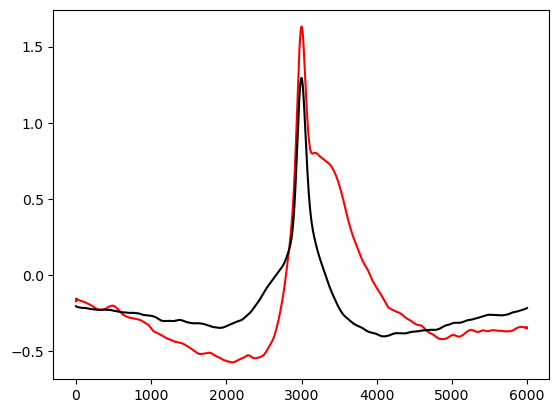

In [3]:
plt.plot(peaksAmygMA.mean(0),'r')
plt.plot(peaksAmygNonMA.mean(0),'k')

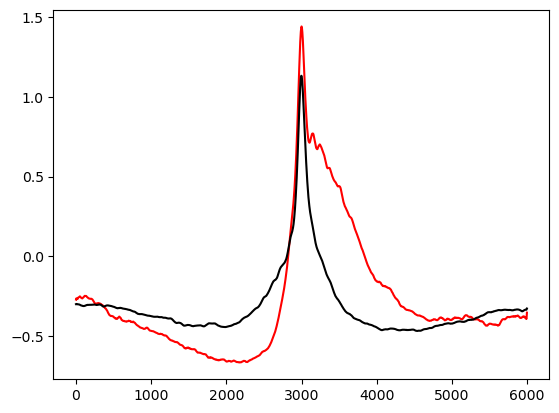

In [4]:
plt.plot(peaksHipMA.mean(0),'r')
plt.plot(peaksHipNonMA.mean(0),'k')

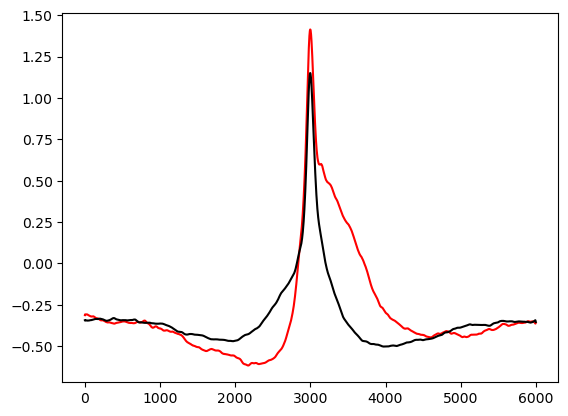

In [3]:
plt.plot(peaksThalMA.mean(0),'r')
plt.plot(peaksThalNonMA.mean(0),'k')

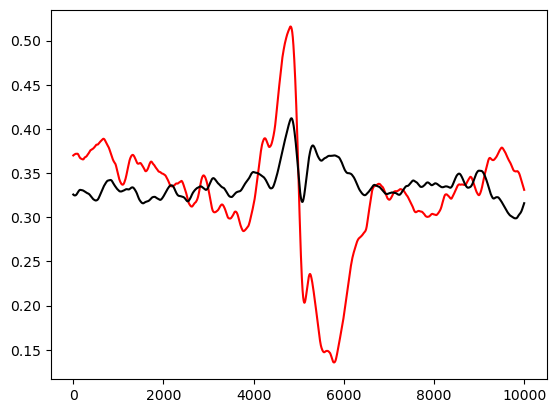

In [3]:
plt.plot(deltaAmygMA.mean(0),'r')
plt.plot(deltaAmygNonMA.mean(0),'k')

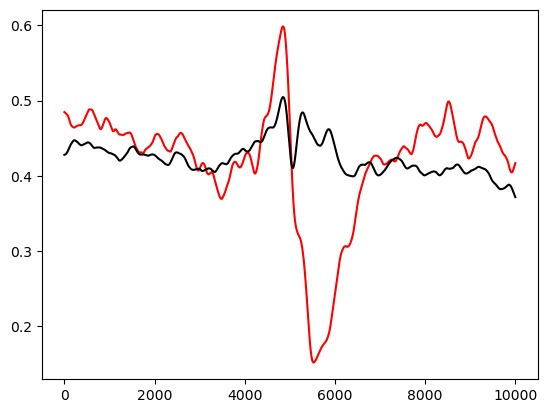

In [5]:
plt.plot(deltaHipMA.mean(0),'r')
plt.plot(deltaHipNonMA.mean(0),'k')

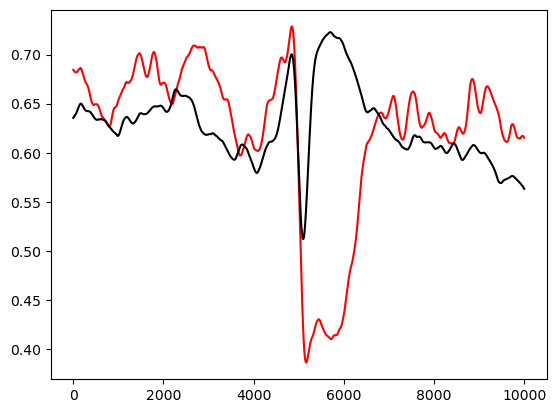

In [4]:
plt.plot(deltaThalMA.mean(0),'r')
plt.plot(deltaThalNonMA.mean(0),'k')

In [17]:
mouseListAmyg = ["AMYG01","AMYG02", "AMYG03"]

peaksAmygMA = []
peaksAmygNonMA = []

deltaAmygMA = []
deltaAmygNonMA = []

sigmaAmygMA = []
sigmaAmygNonMA = []

gammaAmygMA = []
gammaAmygNonMA = []

for m in mouseListAmyg:

    key = {'mouse_name':m}
    
    peaksAmygMAMouse = []
    peaksAmygNonMAMouse = []
    
    sigmaAmygMAMouse = []
    sigmaAmygNonMAMouse = []
    
    deltaAmygMAMouse = []
    deltaAmygNonMAMouse = []
    
    gammaAmygMAMouse = []
    gammaAmygNonMAMouse = []
    
    dates  = (lcProj.LCPeaks & key)
    
    for d in dates:
        
        peaks = d['lc_peaks']
        peaksFlag = d['peaks_flag']
        dff = (lcProj.FibDFF & d).fetch1('dff')
        dff = (dff-np.mean(dff))/np.std(dff)
        times = (lcProj.FibDFF & d).fetch1('timestamps')
        dt = int(1/np.mean(np.diff(times)))
        
        
        delta = (lcProj.MGT & d).fetch1('delta')
        delta = (delta - np.mean(delta)) / np.std(delta)
        
        sigma = (lcProj.MGT & d).fetch1('sigma')
        sigma = (sigma - np.mean(sigma)) / np.std(sigma)
        
        gamma = (lcProj.MGT & d).fetch1('gamma')
        gamma = (gamma - np.mean(sigma)) / np.std(gamma)
        
        timeMGT = np.arange(0, delta.shape[0] / 100, 1 / 100)
        
        dtDff = int(1 / np.mean(np.diff(times)))
        dtMGT = int(1 / np.mean(np.diff(timeMGT)))
        
        FiftySecDff = 50 * dtDff
        FiftySecMGT = 50 * dtMGT
        
        peaksMA = []
        peaksNonMA = []
        
        deltaMA = []
        deltaNonMA = []
        
        sigmaMA = []
        sigmaNonMA = []
        
        gammaMA = []
        gammaNonMA = []
        
        for i, p in enumerate(peaks):
    
            if peaksFlag[i]:
                
                dffChunk =  dff[(p - FiftySecDff):(p + FiftySecDff)]
                
                timeInDff = times[p]
                
                posMGT = findPosFromTimestamps(timeMGT,  timeInDff)
                
                if dffChunk.shape[0] == 2*FiftySecDff:
                    
                    peaksMA.append(dff[(p - FiftySecDff):(p + FiftySecDff)])
                    
                    deltaMA.append(delta[(posMGT - FiftySecMGT):(posMGT + FiftySecMGT)])
                    
                    sigmaMA.append(sigma[(posMGT - FiftySecMGT):(posMGT + FiftySecMGT)])
                    
                    gammaMA.append(gamma[(posMGT - FiftySecMGT):(posMGT + FiftySecMGT)])
                    
                else: 
                    print('Happened at mouse: ' + m)            
                    
            else:
                dffChunk =  dff[(p - FiftySecDff):(p + FiftySecDff)]
                      
                timeInDff = times[p]
                
                posMGT = findPosFromTimestamps(timeMGT,  timeInDff)
                
                if dffChunk.shape[0] == 2* FiftySecDff:
                    
                    peaksNonMA.append(dff[(p - FiftySecDff):(p + FiftySecDff)])
                    
                    deltaNonMA.append(delta[(posMGT - FiftySecMGT):(posMGT + FiftySecMGT)])
                    
                    sigmaNonMA.append(sigma[(posMGT - FiftySecMGT):(posMGT + FiftySecMGT)])
                    
                    gammaNonMA.append(gamma[(posMGT - FiftySecMGT):(posMGT + FiftySecMGT)])
                else: 
                    print('Happened at mouse: ' + m)            
        
        peaksMA = np.array(peaksMA)
        peaksNonMA = np.array(peaksNonMA)
        
        deltaMA = np.array(deltaMA)
        deltaNonMA = np.array(deltaNonMA)
        
        sigmaMA = np.array(sigmaMA)
        sigmaNonMA = np.array(sigmaNonMA)
        
        gammaMA = np.array(gammaMA)
        gammaNonMA = np.array(gammaNonMA)
        
        
        meanPeaksMA = np.mean(peaksMA,0)
        meanPeaksNonMA = np.mean(peaksNonMA,0)
        
        meanDeltaMA = np.mean(deltaMA,0)
        meanDeltaNonMA = np.mean(deltaNonMA,0)

        meanSigmaMA = np.mean(sigmaMA,0)
        meanSigmaNonMA = np.mean(sigmaNonMA,0)
        
        meanGammaMA = np.mean(gammaMA,0)
        meanGammaNonMA = np.mean(gammaNonMA,0)
        
        if meanPeaksMA.shape[0]<6000 or meanPeaksMA.shape[0]>6000:
    
            meanPeaksMA = signal.resample(meanPeaksMA , 6000)
            meanPeaksNonMA = signal.resample(meanPeaksNonMA , 6000)
        
        peaksAmygMAMouse.append(meanPeaksMA)
        peaksAmygNonMAMouse.append(meanPeaksNonMA)
        
        deltaAmygMAMouse.append(meanDeltaMA)
        deltaAmygNonMAMouse.append(meanDeltaNonMA)
        
        sigmaAmygMAMouse.append(meanSigmaMA)
        sigmaAmygNonMAMouse.append(meanSigmaNonMA)
        
        gammaAmygMAMouse.append(meanGammaMA)
        gammaAmygNonMAMouse.append(meanGammaNonMA)
    
    
    peaksAmygMAMouse = np.array(peaksAmygMAMouse)
    peaksAmygNonMAMouse = np.array(peaksAmygNonMAMouse)
        
    deltaAmygMAMouse = np.array(deltaAmygMAMouse)
    deltaAmygNonMAMouse = np.array(deltaAmygNonMAMouse)
    
    sigmaAmygMAMouse = np.array(sigmaAmygMAMouse)
    sigmaAmygNonMAMouse = np.array(sigmaAmygNonMAMouse)
    
    gammaAmygMAMouse = np.array(gammaAmygMAMouse)
    gammaAmygNonMAMouse = np.array(gammaAmygNonMAMouse)

    peaksAmygMA.append(np.mean(peaksAmygMAMouse,0))
    peaksAmygNonMA.append(np.mean(peaksAmygNonMAMouse,0))
    
    deltaAmygMA.append(np.mean(deltaAmygMAMouse,0))
    deltaAmygNonMA.append(np.mean(deltaAmygNonMAMouse,0))
    
    sigmaAmygMA.append(np.mean(sigmaAmygMAMouse,0))
    sigmaAmygNonMA.append(np.mean(sigmaAmygNonMAMouse,0))
    
    gammaAmygMA.append(np.mean(gammaAmygMAMouse,0))
    gammaAmygNonMA.append(np.mean(gammaAmygNonMAMouse,0))


peaksAmygMA = np.array(peaksAmygMA)
peaksAmygNonMA = np.array(peaksAmygNonMA)

deltaAmygMA = np.array(deltaAmygMA)
deltaAmygNonMA = np.array(deltaAmygNonMA)

sigmaAmygMA = np.array(sigmaAmygMA)
sigmaAmygNonMA = np.array(sigmaAmygNonMA)

gammaAmygMA = np.array(gammaAmygMA)
gammaAmygNonMA = np.array(gammaAmygNonMA)


mouseListHip = ["MHIP03","MHIP05","MHIP06"]
peaksHipMA = []
peaksHipNonMA = []

for m in mouseListHip:

    key = {'mouse_name': m}

    peaksHipMAMouse = []
    peaksHipNonMAMouse = []

    dates = (lcProj.LCPeaks & key)

    for d in dates:

        peaks = d['lc_peaks']
        peaksFlag = d['peaks_flag']
        dff = (lcProj.FibDFF & d).fetch1('dff')
        dff = (dff-np.mean(dff))/np.std(dff)
        times = (lcProj.FibDFF & d).fetch1('timestamps')
        dt = int(1 / np.mean(np.diff(times)))

        FiftySec = 50 * dt

        peaksMA = []
        peaksNonMA = []

        for i, p in enumerate(peaks):

            if peaksFlag[i]:
                           
                dffChunk =  dff[(p - FiftySec):(p + FiftySec)]
                if dffChunk.shape[0] == 2* FiftySec:
                    peaksMA.append(dff[(p - FiftySec):(p + FiftySec)])              
                else: 
                   print('Happened at mouse: ' + m)
            else:
                          
                dffChunk =  dff[(p - FiftySec):(p + FiftySec)]
                if dffChunk.shape[0] == 2* FiftySec:
                    peaksNonMA.append(dff[(p - FiftySec):(p + FiftySec)])
                else: 
                    print('Happened at mouse: ' + m)

        peaksMA = np.array(peaksMA)
        peaksNonMA = np.array(peaksNonMA)

        meanPeaksMA = np.mean(peaksMA, 0)
        meanPeaksNonMA = np.mean(peaksNonMA, 0)

        if meanPeaksMA.shape[0] < 6000 or meanPeaksMA.shape[0] > 6000:
            meanPeaksMA = signal.resample(meanPeaksMA, 6000)
            meanPeaksNonMA = signal.resample(meanPeaksNonMA, 6000)

        peaksHipMAMouse.append(meanPeaksMA)
        peaksHipNonMAMouse.append(meanPeaksNonMA)

    peaksHipMAMouse = np.array(peaksHipMAMouse)
    peaksHipNonMAMouse = np.array(peaksHipNonMAMouse)

    peaksHipMA.append(np.mean(peaksHipMAMouse, 0))
    peaksHipNonMA.append(np.mean(peaksHipNonMAMouse, 0))

peaksHipMA = np.array(peaksHipMA)
peaksHipNonMA = np.array(peaksHipNonMA)



mouseListPfc = ["MPC05","MPC06"]
peaksPfcMA = []
peaksPfcNonMA = []

for m in mouseListPfc :

    key = {'mouse_name': m}

    peaksPfcMAMouse = []
    peaksPfcNonMAMouse = []
    dates = (lcProj.LCPeaks & key)

    for d in dates:

        peaks = d['lc_peaks']
        peaksFlag = d['peaks_flag']
        dff = (lcProj.FibDFF & d).fetch1('dff')
        dff = (dff-np.mean(dff))/np.std(dff)
        times = (lcProj.FibDFF & d).fetch1('timestamps')
        dt = int(1 / np.mean(np.diff(times)))

        FiftySec = 50 * dt

        peaksMA = []
        peaksNonMA = []

        for i, p in enumerate(peaks):

            if peaksFlag[i]:
                
                dffChunk =  dff[(p - FiftySec):(p + FiftySec)]
                if dffChunk.shape[0] == 2* FiftySec:
                    peaksMA.append(dff[(p - FiftySec):(p + FiftySec)])
                else: 
                    print('Happened at mouse: ' + m)            
                    
            else:
            
                dffChunk =  dff[(p - FiftySec):(p + FiftySec)]
                if dffChunk.shape[0] == 2*FiftySec:
                    peaksNonMA.append(dff[(p - FiftySec):(p + FiftySec)])
                else: 
                    print('Happened at mouse: ' + m)            
                    

        peaksMA = np.array(peaksMA)
        peaksNonMA = np.array(peaksNonMA)

        meanPeaksMA = np.mean(peaksMA, 0)
        meanPeaksNonMA = np.mean(peaksNonMA, 0)

        if meanPeaksMA.shape[0] < 6000 or meanPeaksMA.shape[0] > 6000:
            meanPeaksMA = signal.resample(meanPeaksMA, 6000)
            meanPeaksNonMA = signal.resample(meanPeaksNonMA, 6000)

        peaksPfcMAMouse.append(meanPeaksMA)
        peaksPfcNonMAMouse.append(meanPeaksNonMA)

    peaksPfcMAMouse = np.array(peaksPfcMAMouse)
    peaksPfcNonMAMouse = np.array(peaksPfcNonMAMouse)

    peaksPfcMA.append(np.mean(peaksPfcMAMouse, 0))
    peaksPfcNonMA.append(np.mean(peaksPfcNonMAMouse, 0))

peaksPfcMA = np.array(peaksPfcMA)
peaksPfcNonMA = np.array(peaksPfcNonMA)

mouseListThal = ["THAL01","THAL02","THAL04","THAL06"]
peaksThalMA = []
peaksThalNonMA = []

for m in mouseListThal:

    key = {'mouse_name': m}

    peaksThalMAMouse = []
    peaksThalNonMAMouse = []
    dates = (lcProj.LCPeaks & key)

    for d in dates:

        peaks = d['lc_peaks']
        peaksFlag = d['peaks_flag']
        dff = (lcProj.FibDFF & d).fetch1('dff')
        dff = (dff-np.mean(dff))/np.std(dff)
        times = (lcProj.FibDFF & d).fetch1('timestamps')
        dt = int(1 / np.mean(np.diff(times)))

        FiftySec = 50 * dt

        peaksMA = []
        peaksNonMA = []

        for i, p in enumerate(peaks):

            if peaksFlag[i]:
                
                dffChunk =  dff[(p - FiftySec):(p + FiftySec)]
                if dffChunk.shape[0] == 2* FiftySec:
                    peaksMA.append(dff[(p - FiftySec):(p + FiftySec)])
                else: 
                    print('Happened at mouse: ' + m)            
                    
            else:
                dffChunk =  dff[(p - FiftySec):(p + FiftySec)]
                if dffChunk.shape[0] == 2* FiftySec:
                    peaksNonMA.append(dff[(p - FiftySec):(p + FiftySec)])
                else: 
                    print('Happened at mouse: ' + m)            
                    

        peaksMA = np.array(peaksMA)
        peaksNonMA = np.array(peaksNonMA)

        meanPeaksMA = np.mean(peaksMA, 0)
        meanPeaksNonMA = np.mean(peaksNonMA, 0)

        if meanPeaksMA.shape[0] < 6000 or meanPeaksMA.shape[0] > 6000:
            meanPeaksMA = signal.resample(meanPeaksMA, 6000)
            meanPeaksNonMA = signal.resample(meanPeaksNonMA, 6000)

        peaksThalMAMouse.append(meanPeaksMA)
        peaksThalNonMAMouse.append(meanPeaksNonMA)

    peaksThalMAMouse = np.array(peaksThalMAMouse)
    peaksThalNonMAMouse = np.array(peaksThalNonMAMouse)

    peaksThalMA.append(np.mean(peaksThalMAMouse, 0))
    peaksThalNonMA.append(np.mean(peaksThalNonMAMouse, 0))

peaksThalMA = np.array(peaksThalMA)
peaksThalNonMA = np.array(peaksThalNonMA)

Happened at mouse: THAL04
Happened at mouse: THAL04


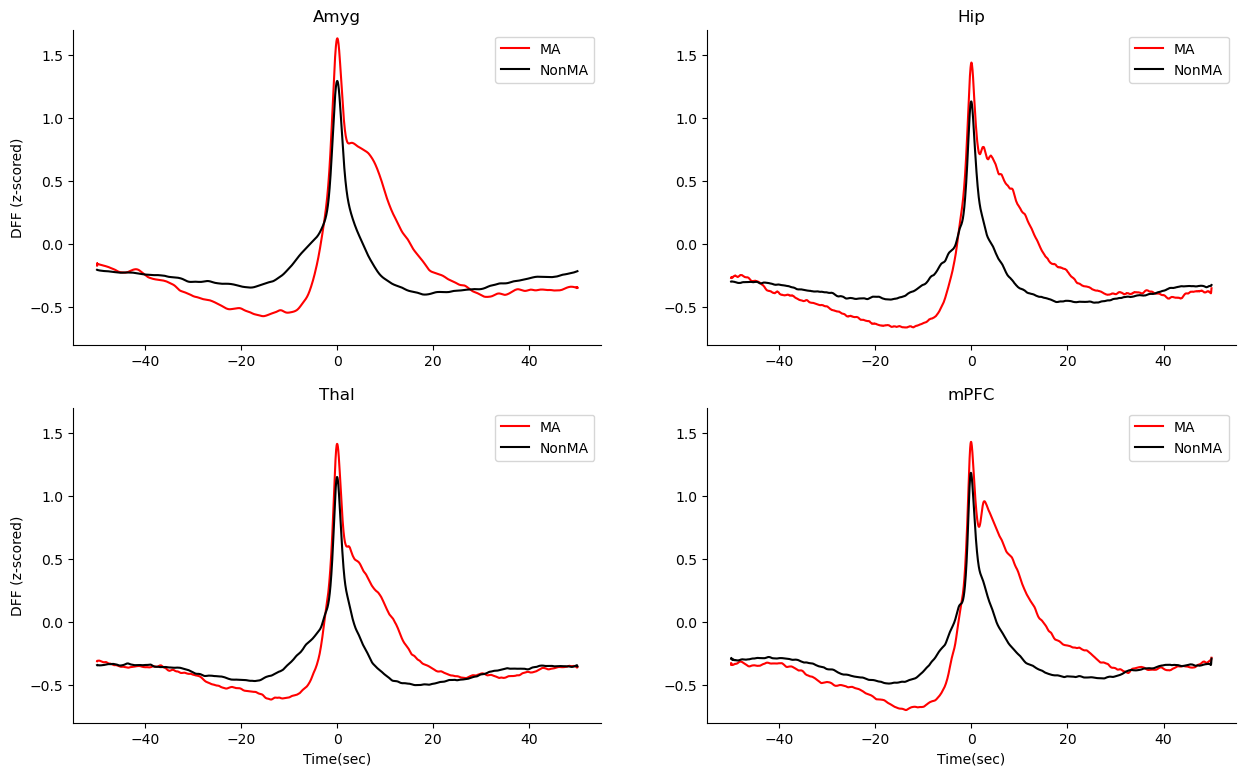

In [37]:
fig, ax= plt.subplots(2, 2,figsize=(15, 9))

meanAmygMA = np.mean(peaksAmygMA,0)
meanAmygNonMA = np.mean(peaksAmygNonMA,0)

meanHipMA = np.mean(peaksHipMA,0)
meanHipNonMA = np.mean(peaksHipNonMA,0)

meanThalMA = np.mean(peaksThalMA,0)
meanThalNonMA = np.mean(peaksThalNonMA,0)

meanPfcMA = np.mean(peaksPfcMA,0)
meanPfcNonMA = np.mean(peaksPfcNonMA,0)

timeVec = np.arange(-50,50, 1/60)

ax[0,0].plot(timeVec, meanAmygMA, 'r')
ax[0,0].plot(timeVec, meanAmygNonMA, 'k')
ax[0,0].set_ylim(-0.8,1.7)
ax[0,0].set_ylabel('DFF (z-scored)')
ax[0,0].set_title('Amyg')
ax[0,0].legend(['MA','NonMA'])
ax[0,0].spines[['right', 'top']].set_visible(False)

ax[0,1].plot(timeVec, meanHipMA, 'r')
ax[0,1].plot(timeVec, meanHipNonMA , 'k')
ax[0,1].set_ylim(-0.8,1.7)
ax[0,1].set_title('Hip')
ax[0,1].legend(['MA','NonMA'])
ax[0,1].spines[['right', 'top']].set_visible(False)

ax[1,0].plot(timeVec, meanThalMA, 'r')
ax[1,0].plot(timeVec, meanThalNonMA , 'k')
ax[1,0].set_ylim(-0.8,1.7)
ax[1,0].set_xlabel('Time(sec)')
ax[1,0].set_ylabel('DFF (z-scored)')
ax[1,0].set_title('Thal')
ax[1,0].legend(['MA','NonMA'])
ax[1,0].spines[['right', 'top']].set_visible(False)

ax[1,1].plot(timeVec, meanPfcMA, 'r')
ax[1,1].plot(timeVec, meanPfcNonMA , 'k')
ax[1,1].set_ylim(-0.8,1.7)
ax[1,1].set_xlabel('Time(sec)')
ax[1,1].set_title('mPFC')
ax[1,1].legend(['MA','NonMA'])
ax[1,1].spines[['right', 'top']].set_visible(False)

In [40]:
mouseListThal = ["THAL06"]
peaksThalMA = []
peaksThalNonMA = []

for m in mouseListThal:

    key = {'mouse_name': m}

    peaksThalMAMouse = []
    peaksThalNonMAMouse = []
    dates = (lcProj.LCPeaks & key)

    for d in dates:

        peaks = d['lc_peaks']
        peaksFlag = d['peaks_flag']
        dff = (lcProj.FibDFF & d).fetch1('dff')
        dff = (dff-np.mean(dff))/np.std(dff)
        times = (lcProj.FibDFF & d).fetch1('timestamps')
        dt = int(1 / np.mean(np.diff(times)))


mouse_name unique mouse name,session_date,session_time,project_id,initials initials used for this person in the lab,rig_room for example Neurobau2,file_name
AMYG01,2023-11-30,08:47:08,LC Photometry of Projection Neurons Baseline,GF,Neurobau1.27,\\nasdcsr.unil.ch\RECHERCHE\FAC\FBM\DNF\aluthi1\fbm_move\D2c\_PROJECTS\PROJECT_Georgios\LC_Proj_Neurons\Ephys\AMYG01\231130_AMYG01_12hBas1_bt.mat
AMYG01,2023-12-11,08:22:50,LC Photometry of Projection Neurons Baseline,GF,Neurobau1.27,\\nasdcsr.unil.ch\RECHERCHE\FAC\FBM\DNF\aluthi1\fbm_move\D2c\_PROJECTS\PROJECT_Georgios\LC_Proj_Neurons\Ephys\AMYG01\231211_AMYG01_12hBas2_bt.mat
AMYG01,2024-01-08,09:18:32,LC Photometry of Projection Neurons with SD,GF,Neurobau1.27,\\nasdcsr.unil.ch\RECHERCHE\FAC\FBM\DNF\aluthi1\fbm_move\D2c\_PROJECTS\PROJECT_Georgios\LC_Proj_Neurons\Ephys\AMYG01\240108_AMYG01_4hSD_bt.mat
AMYG01,2024-01-29,08:45:38,LC Photometry of Projection Neurons with SSD,GF,Neurobau1.27,\\nasdcsr.unil.ch\RECHERCHE\FAC\FBM\DNF\aluthi1\fbm_move\D2c\_PROJECTS\PROJECT_Georgios\LC_Proj_Neurons\Ephys\AMYG01\240129_AMYG01_4hSSD_bt.mat
AMYG02,2024-01-16,08:50:13,LC Photometry of Projection Neurons Baseline,GF,Neurobau1.27,\\nasdcsr.unil.ch\RECHERCHE\FAC\FBM\DNF\aluthi1\fbm_move\D2c\_PROJECTS\PROJECT_Georgios\LC_Proj_Neurons\Ephys\AMYG02\240116_AMYG02_12hBas1_bt.mat
AMYG02,2024-01-18,08:23:11,LC Photometry of Projection Neurons Baseline,GF,Neurobau1.27,\\nasdcsr.unil.ch\RECHERCHE\FAC\FBM\DNF\aluthi1\fbm_move\D2c\_PROJECTS\PROJECT_Georgios\LC_Proj_Neurons\Ephys\AMYG02\240118_AMYG02_12hBas2_bt.mat
AMYG02,2024-02-06,08:37:21,LC Photometry of Projection Neurons Baseline,GF,Neurobau1.27,\\nasdcsr.unil.ch\RECHERCHE\FAC\FBM\DNF\aluthi1\fbm_move\D2c\_PROJECTS\PROJECT_Georgios\LC_Proj_Neurons\Ephys\AMYG02\240206_AMYG02_12hBas3_bt.mat
AMYG02,2024-02-12,08:35:40,LC Photometry of Projection Neurons with SD,GF,Neurobau1.27,\\nasdcsr.unil.ch\RECHERCHE\FAC\FBM\DNF\aluthi1\fbm_move\D2c\_PROJECTS\PROJECT_Georgios\LC_Proj_Neurons\Ephys\AMYG02\240212_AMYG02_4hSD_bt.mat
AMYG02,2024-02-14,08:06:13,LC Photometry of Projection Neurons Baseline,GF,Neurobau1.27,\\nasdcsr.unil.ch\RECHERCHE\FAC\FBM\DNF\aluthi1\fbm_move\D2c\_PROJECTS\PROJECT_Georgios\LC_Proj_Neurons\Ephys\AMYG02\240214_AMYG02_12hBas4_bt.mat
AMYG02,2024-02-29,09:05:37,LC Photometry of Projection Neurons with SSD,GF,Neurobau1.27,\\nasdcsr.unil.ch\RECHERCHE\FAC\FBM\DNF\aluthi1\fbm_move\D2c\_PROJECTS\PROJECT_Georgios\LC_Proj_Neurons\Ephys\AMYG02\240229_AMYG02_4hSSD_bt.mat


In [31]:
m = "THAL06"

key = {'mouse_name': m}

peaksThalMAMouse = []
peaksThalNonMAMouse = []
dates = (lcProj.LCPeaks & key & 'session_date = "2024-04-15"').fetch1()
d = dates 
peaks = d['lc_peaks']
peaksFlag = d['peaks_flag']
times = (lcProj.FibDFF & d).fetch1('timestamps')

dff = (lcProj.FibDFF & d).fetch1('dff')
dff = (dff-np.mean(dff))/np.std(dff)

delta = (lcProj.MGT & key & 'session_date = "2024-04-15"').fetch1('delta')
delta = (delta-np.mean(delta))/np.std(delta)

sigma = (lcProj.MGT & key & 'session_date = "2024-04-15"').fetch1('sigma')
sigma = (sigma-np.mean(sigma))/np.std(sigma)

gamma = (lcProj.MGT & key & 'session_date = "2024-04-15"').fetch1('gamma')
gamma = (gamma-np.mean(sigma))/np.std(gamma)

timeMGT = np.arange(0,delta.shape[0]/100, 1/100)

dtDff = int(1 / np.mean(np.diff(times)))
dtMGT = int(1 / np.mean(np.diff(timeMGT)))

FiftySecDff = 50 * dtDff 
FiftySecMGT = 50 * dtMGT 

peaksMA = []
peaksNonMA = []

deltaMA = []
deltaNonMA = []

sigmaMA = []
sigmaNonMA = []

gammaMA = []
gammaNonMA = []


In [33]:
for i, p in enumerate(peaks):

    if peaksFlag[i]:
        
        dffChunk =  dff[(p - FiftySecDff):(p + FiftySecDff)]
        
        timeInDff = times[p]
        
        posMGT = findPosFromTimestamps(timeMGT,  timeInDff)
        
        if dffChunk.shape[0] == 2*FiftySecDff:
            
            peaksMA.append(dff[(p - FiftySecDff):(p + FiftySecDff)])
            
            deltaMA.append(delta[(posMGT - FiftySecMGT):(posMGT + FiftySecMGT)])
            
            sigmaMA.append(sigma[(posMGT - FiftySecMGT):(posMGT + FiftySecMGT)])
            
            gammaMA.append(gamma[(posMGT - FiftySecMGT):(posMGT + FiftySecMGT)])
            
        else: 
            print('Happened at mouse: ' + m)            
            
    else:
        dffChunk =  dff[(p - FiftySecDff):(p + FiftySecDff)]
              
        timeInDff = times[p]
        
        posMGT = findPosFromTimestamps(timeMGT,  timeInDff)
        
        if dffChunk.shape[0] == 2* FiftySecDff:
            
            peaksNonMA.append(dff[(p - FiftySecDff):(p + FiftySecDff)])
            
            deltaNonMA.append(delta[(posMGT - FiftySecMGT):(posMGT + FiftySecMGT)])
            
            sigmaNonMA.append(sigma[(posMGT - FiftySecMGT):(posMGT + FiftySecMGT)])
            
            gammaNonMA.append(gamma[(posMGT - FiftySecMGT):(posMGT + FiftySecMGT)])
        else: 
            print('Happened at mouse: ' + m)            


In [34]:
peaksMA = np.array(peaksMA)
peaksNonMA = np.array(peaksNonMA)

deltaMA = np.array(deltaMA)
deltaNonMA = np.array(deltaNonMA)

sigmaMA = np.array(sigmaMA)
sigmaNonMA = np.array(sigmaNonMA)

gammaMA = np.array(gammaMA)
gammaNonMA = np.array(gammaNonMA)

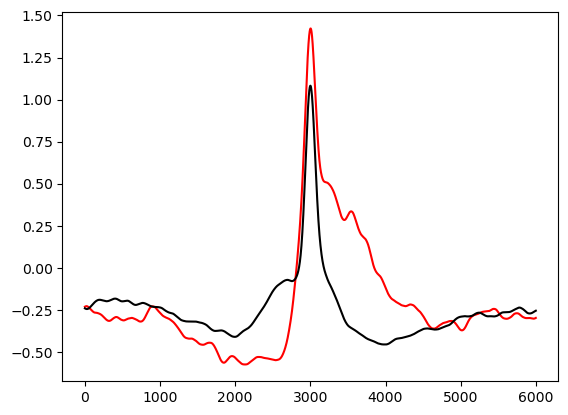

In [35]:
plt.plot(peaksMA.mean(0),'r')
plt.plot(peaksNonMA.mean(0),'k')

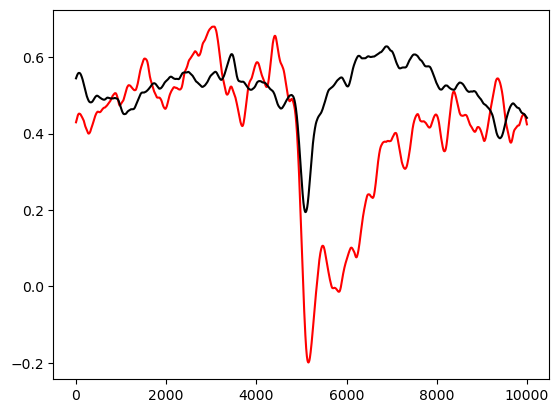

In [36]:
plt.plot(deltaMA.mean(0),'r')
plt.plot(deltaNonMA.mean(0),'k')

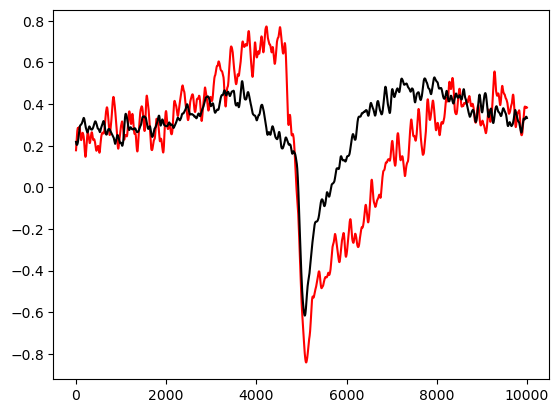

In [37]:
plt.plot(sigmaMA.mean(0),'r')
plt.plot(sigmaNonMA.mean(0),'k')

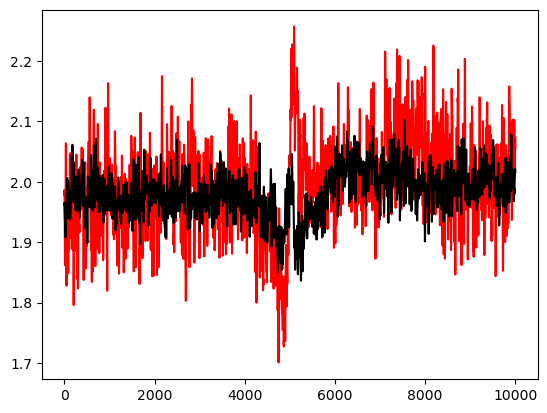

In [38]:
plt.plot(gammaMA.mean(0),'r')
plt.plot(gammaNonMA.mean(0),'k')

In [12]:
timeMGT = np.arange(0,delta.shape[0]/100, 1/100)


In [5]:
timeMGT = np.arange(0,delta.shape[0]/100, 1/100)
dtMGT = int(1 / np.mean(np.diff(timeMGT)))

In [6]:
dtMGT

100